In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

train_directory = "/Users/evangelosgeraridis/Desktop/MEAZON/September 2022"
test_directory = "/Users/evangelosgeraridis/Desktop/MEAZON/October 2022"


train_dataframes = {}
test_dataframes = {}


for file in os.listdir(train_directory):
    file_path = os.path.join(train_directory, file)
    if os.path.isfile(file_path) and file.endswith(".csv"):
        df = pd.read_csv(file_path)
        train_dataframes[file] = df

# Process test data
for file in os.listdir(test_directory):
    file_path = os.path.join(test_directory, file)
    if os.path.isfile(file_path) and file.endswith(".csv"):
        df = pd.read_csv(file_path)
        test_dataframes[file] = df

In [2]:
entry_counts = []

# Count entries in train DataFrames
for name, df in train_dataframes.items():
    count_value = df.count()
    entry_counts.append(count_value.tolist())

# Show the minimum value of entry_counts
min_value = min(entry_counts)
print("Minimum value of entry_counts:", min_value)


Minimum value of entry_counts: [36615, 36615, 36615, 36615, 36615, 36615]


In [3]:
entry_counts = []

# Count entries in train DataFrames
for name, df in test_dataframes.items():
    count_value = df.count()
    entry_counts.append(count_value.tolist())

# Show the minimum value of entry_counts
min_value = min(entry_counts)
print("Minimum value of entry_counts:", min_value)


Minimum value of entry_counts: [16042, 16042, 16042, 16042, 16042, 16042]


In [4]:
limited_train_dataframes = {}

# Apply the limit to each train DataFrame
for key, df in train_dataframes.items():
    limited_train_dataframes[key] = df.iloc[:36615]


In [5]:
limited_test_dataframes = {}

# Apply the limit to each train DataFrame
for key, df in test_dataframes.items():
    limited_test_dataframes[key] = df.iloc[:16042]


In [6]:
washing_machine_train = limited_train_dataframes['washing_machineS.csv'].set_index('ts').dropna()
aggregated_train = limited_train_dataframes['AggregatedS.csv'].set_index('ts').dropna()
dishwasher_train = limited_train_dataframes['dishwasherS.csv'].set_index('ts').dropna()
water_heater_train = limited_train_dataframes['water_heaterS.csv'].set_index('ts').dropna()
fridge_train = limited_train_dataframes['fridgeS.csv'].set_index('ts').dropna()
microwave_train = limited_train_dataframes['microwaveS.csv'].set_index('ts').dropna()
hotplate_train = limited_train_dataframes['hotplateS.csv'].set_index('ts').dropna()

In [7]:
washing_machine_test = limited_test_dataframes['washing_machineO.csv'].set_index('ts').dropna()
aggregated_test = limited_test_dataframes['AggregatedO.csv'].set_index('ts').dropna()
dishwasher_test = limited_test_dataframes['dishwasherO.csv'].set_index('ts').dropna()
water_heater_test = limited_test_dataframes['water_heaterO.csv'].set_index('ts').dropna()
fridge_test = limited_test_dataframes['fridgeO.csv'].set_index('ts').dropna()
microwave_test = limited_test_dataframes['microwaveO.csv'].set_index('ts').dropna()
hotplate_test = limited_test_dataframes['hotplateO.csv'].set_index('ts').dropna()

In [8]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score


class CO:
    def __init__(self, num_states=2, num_cluster=2):
        self.num_states = num_states
        self.num_cluster = num_cluster
        self.models = None

    def train(self, X):
        X_agg = self.create_input(X)
        self.models = self.train_co(X_agg)
        return self.models

    def create_input(self, X):
        n_samples, n_features = X.shape
        X_agg = np.zeros((n_samples, self.num_states))
        for i in range(n_samples):
            for j in range(self.num_states):
                X_agg[i, j] = np.sum(X[i, j * (n_features // self.num_states):(j + 1) * (n_features // self.num_states)])
        return X_agg

    def train_co(self, X):
        num_samples, num_features = X.shape
        models = []
        for k in range(num_features):
            model = KMeans(n_clusters=self.num_cluster).fit(X[:, k].reshape(-1, 1))
            models.append(model)
        return models

    def disaggregate(self, X):
        n_samples, n_features = X.shape
        X_agg = self.create_input(X)
        Y = np.zeros((n_samples, n_features))
        for k in range(n_features):
            cluster_labels = self.models[k].predict(X_agg[:, k].reshape(-1, 1))
            cluster_centers = self.models[k].cluster_centers_
            for i, label in enumerate(cluster_labels):
                Y[i, k] = cluster_centers[label]
        return Y

    def calculate_rmse(self, X_true, X_pred):
        return np.sqrt(mean_squared_error(X_true, X_pred))

    def calculate_mae(self, X_true, X_pred):
        return mean_absolute_error(X_true, X_pred)

    def calculate_rmae(self, X_true, X_pred):
        rmse = self.calculate_rmse(X_true, X_pred)
        return rmse / np.mean(X_true)

    def calculate_mse(self, X_true, X_pred):
        return mean_squared_error(X_true, X_pred)

    
X_train_fridge, X_test_fridge, Y_train_fridge, Y_test_fridge = aggregated_train.values, aggregated_test.values, fridge_train.values, fridge_test.values

co_disaggregator_fridge = CO(num_states=5, num_cluster=5)
co_disaggregator_fridge.train(X_train_fridge)

disaggregated_data_fridge = co_disaggregator_fridge.disaggregate(X_test_fridge)

columns = ["pwrA", "apwrA", "curA", "cltA", "screA"]

# Create an empty dictionary to store the metrics
metrics = {}

# Calculate and store the metrics for each column
for column in columns:
    column_true = Y_test_fridge[:, columns.index(column)]
    column_pred = disaggregated_data_fridge[:, columns.index(column)]
    
    rmse = co_disaggregator_fridge.calculate_rmse(column_true, column_pred)
    mae = co_disaggregator_fridge.calculate_mae(column_true, column_pred)
    rmae = co_disaggregator_fridge.calculate_rmae(column_true, column_pred)
    mse = co_disaggregator_fridge.calculate_mse(column_true, column_pred)
    r_squared = r2_score(column_true, column_pred)
    
    metrics[column] = {
        'RMSE': rmse,
        'MAE': mae,
        'RMAE': rmae,
        'MSE': mse,
        'R-squared': r_squared
    }

# Print the metrics for each column
for column, metrics_dict in metrics.items():
    print(f"Metrics for {column}:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value}")
    print()


/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

Metrics for pwrA:
RMSE: 401.9744390263949
MAE: 303.8764438911335
RMAE: 2.32066394183287
MSE: 161583.4496305849
R-squared: -0.9349927699827651

Metrics for apwrA:
RMSE: 444.97806564026854
MAE: 333.8348392518715
RMAE: 2.076321114266205
MSE: 198005.47890095515
R-squared: -0.8867740683559833

Metrics for curA:
RMSE: 2.011658488413923
MAE: 1.5018912459581293
RMAE: 2.0799233302320976
MSE: 4.046769874007788
R-squared: -0.881589805213816

Metrics for cltA:
RMSE: 2.545031051026977
MAE: 2.0566749665587043
RMAE: 0.011433144593488261
MSE: 6.4771830506914805
R-squared: -0.4794102032436567

Metrics for screA:
RMSE: 1.0480723217603143
MAE: 0.9626701023860211
RMAE: 1.3869881846705927
MSE: 1.0984555916400558
R-squared: -63.839987883497756



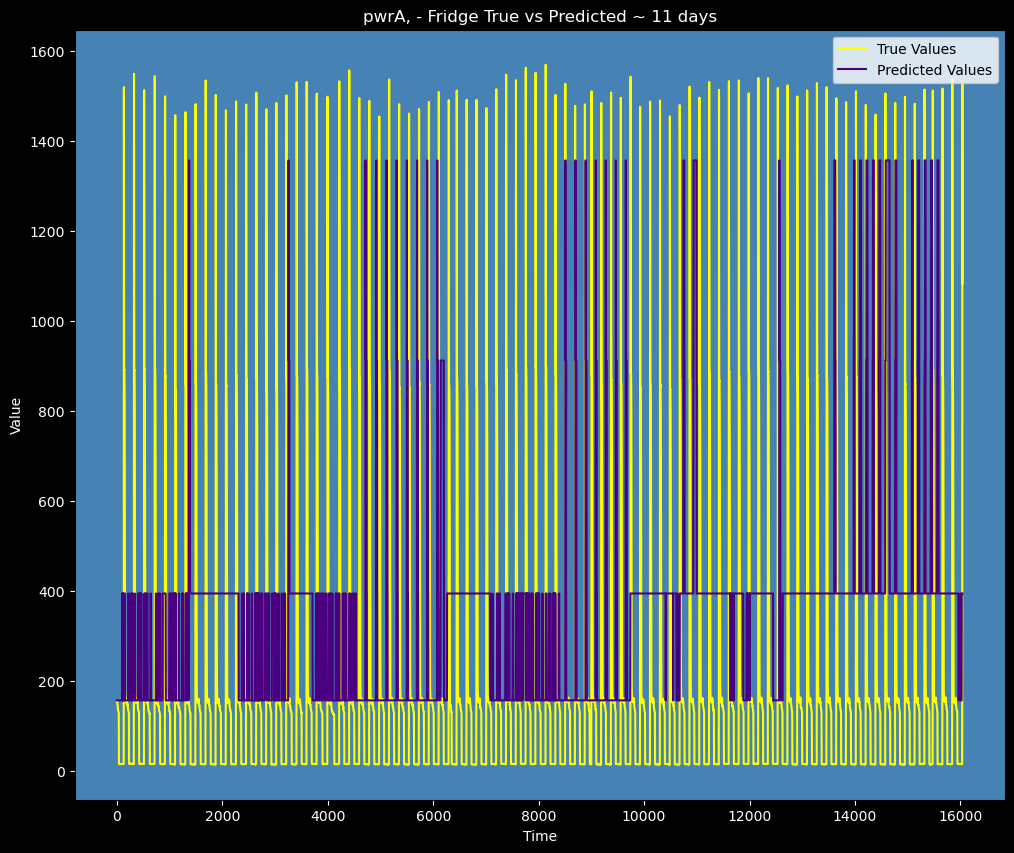

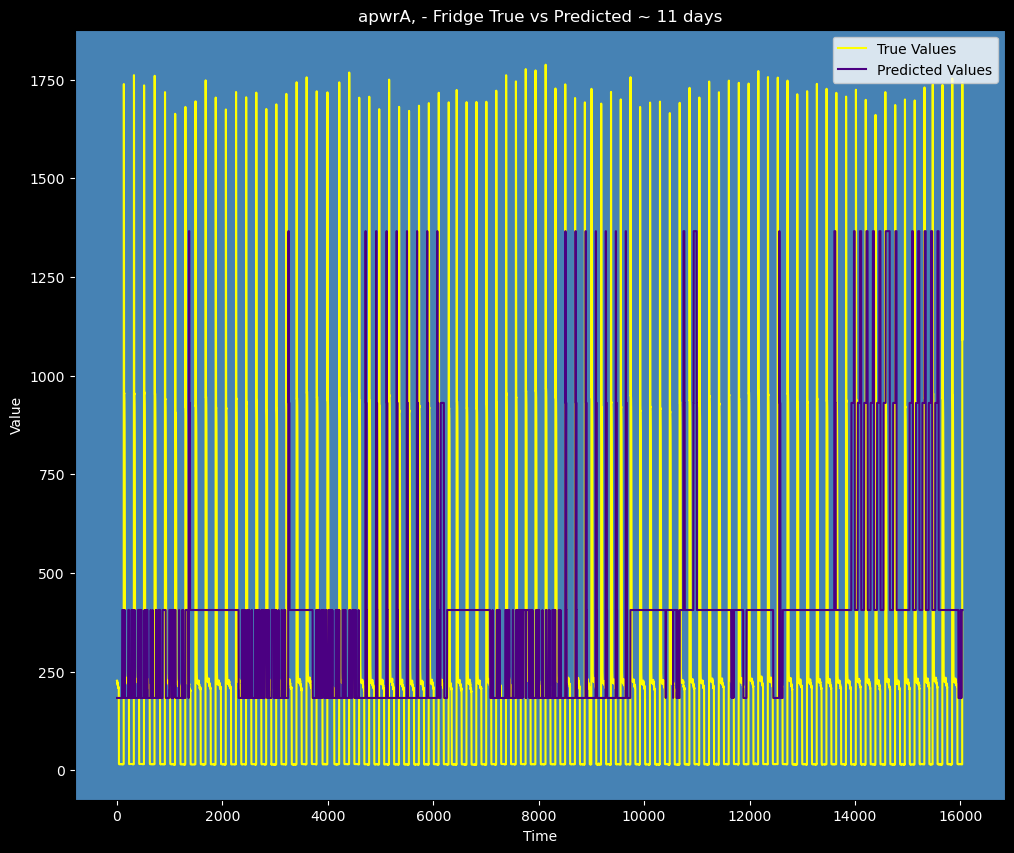

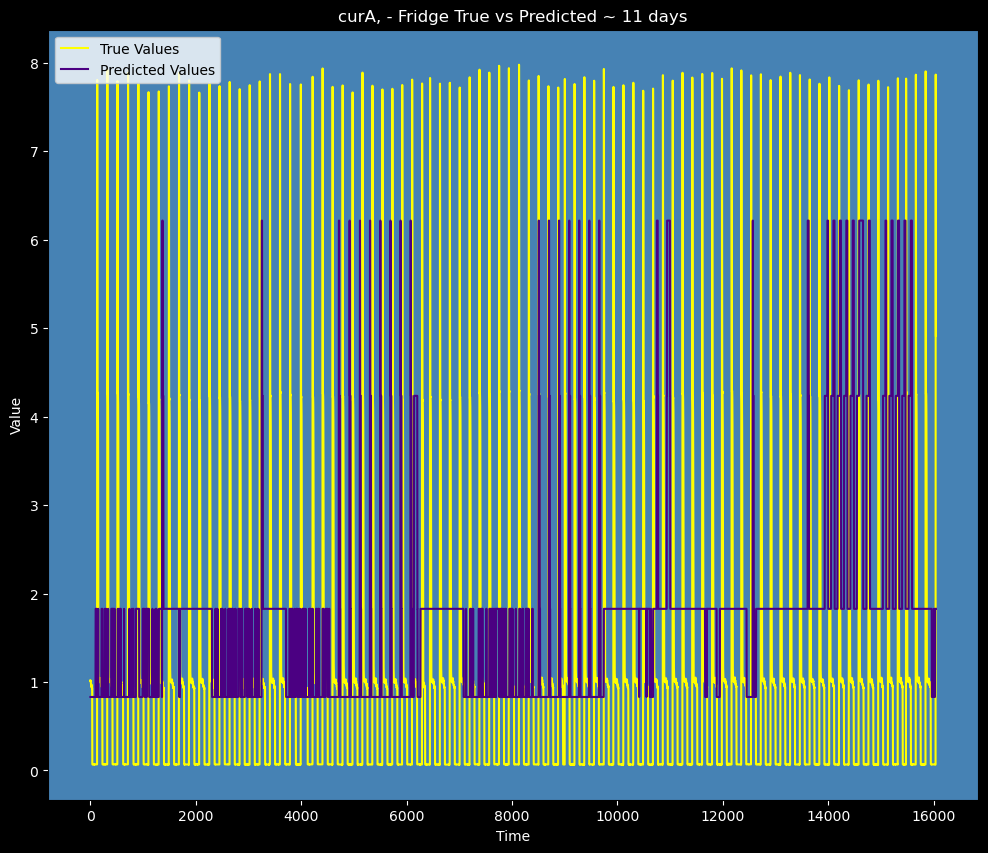

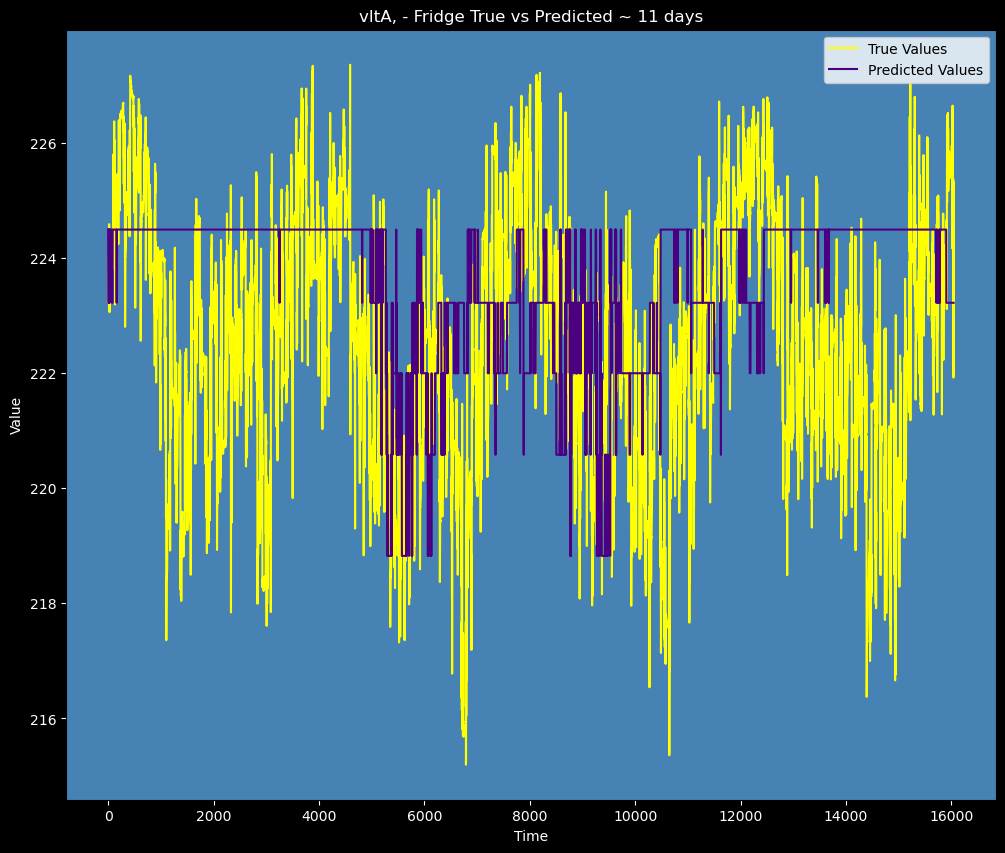

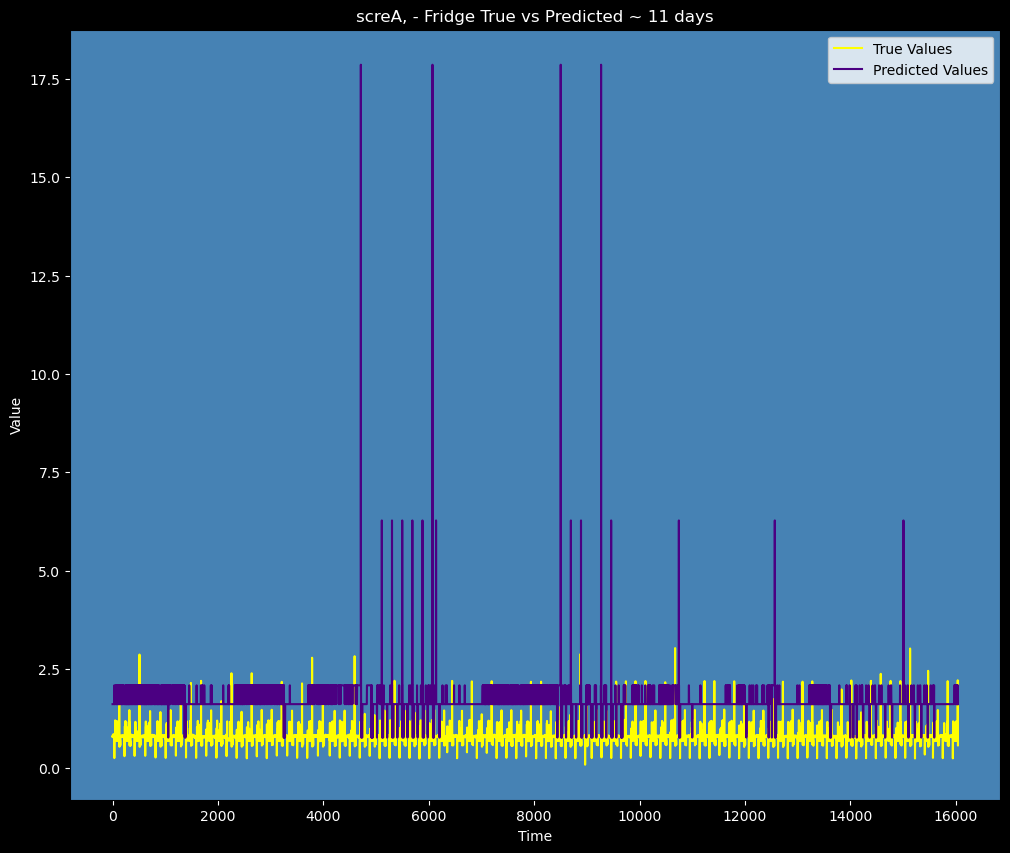

In [11]:
import matplotlib.pyplot as plt
column_names = ['pwrA', 'apwrA','curA', 'vltA','screA']
j = 0
# Plotting the predicted values against the true values for each column
for i in range(Y_test_fridge.shape[1]):
    column_name = f"Column {i+1}"
    column_true = Y_test_fridge[:, i]
    column_pred = disaggregated_data_fridge[:, i]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_facecolor('black')
    
    ax.plot(column_true, label="True Values", color='yellow')
    ax.plot(column_pred, label="Predicted Values", color = 'indigo')
    ax.set_xlabel("Time",color= 'white')
    ax.set_ylabel("Value", color = 'white')
    ax.set_title(column_names[j]+", - Fridge True vs Predicted ~ 11 days", color = 'white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.legend()
    
    # Change the color of the plot background
    ax.set_facecolor('steelblue')
    
    plt.show()
    j +=1

In [12]:
 ## Washing Machine ##   
    
    
X_train_washing_machine, X_test_washing_machine, Y_train_washing_machine, Y_test_washing_machine = aggregated_train.values, aggregated_test.values, washing_machine_train.values, washing_machine_test.values

co_disaggregator_washing_machine = CO(num_states=5, num_cluster=5)
co_disaggregator_washing_machine.train(X_train_washing_machine)

disaggregated_data_washing_machine = co_disaggregator_washing_machine.disaggregate(X_test_washing_machine)

columns = ["pwrA", "apwrA", "curA", "cltA", "screA"]

# Create an empty dictionary to store the metrics
metrics = {}

# Calculate and store the metrics for each column
for column in columns:
    column_true = Y_test_washing_machine[:, columns.index(column)]
    column_pred = disaggregated_data_washing_machine[:, columns.index(column)]
    
    rmse = co_disaggregator_washing_machine.calculate_rmse(column_true, column_pred)
    mae = co_disaggregator_washing_machine.calculate_mae(column_true, column_pred)
    rmae = co_disaggregator_washing_machine.calculate_rmae(column_true, column_pred)
    mse = co_disaggregator_washing_machine.calculate_mse(column_true, column_pred)
    r_squared = r2_score(column_true, column_pred)
    
    metrics[column] = {
        'RMSE': rmse,
        'MAE': mae,
        'RMAE': rmae,
        'MSE': mse,
        'R-squared': r_squared
    }

# Print the metrics for each column
for column, metrics_dict in metrics.items():
    print(f"Metrics for {column}:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value}")
    print()


/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

Metrics for pwrA:
RMSE: 787.2818704923553
MAE: 545.6653136098886
RMAE: 2.14124533416902
MSE: 619812.7436059418
R-squared: -0.14661791984972572

Metrics for apwrA:
RMSE: 798.370403134382
MAE: 574.930927188401
RMAE: 2.1440034630686506
MSE: 637395.3006009555
R-squared: -0.17843850494359326

Metrics for curA:
RMSE: 3.6467529614069893
MAE: 2.607388835771955
RMAE: 2.143335115264928
MSE: 13.298807161530647
R-squared: -0.1730714001718503

Metrics for cltA:
RMSE: 2.810389444403809
MAE: 2.3303040878390227
RMAE: 0.0126540624555791
MSE: 7.898288829216352
R-squared: -0.6470349657491266

Metrics for screA:
RMSE: 0.8388420204094172
MAE: 0.6848612101568566
RMAE: 0.8044438470591583
MSE: 0.7036559352045532
R-squared: -4.920383027958761



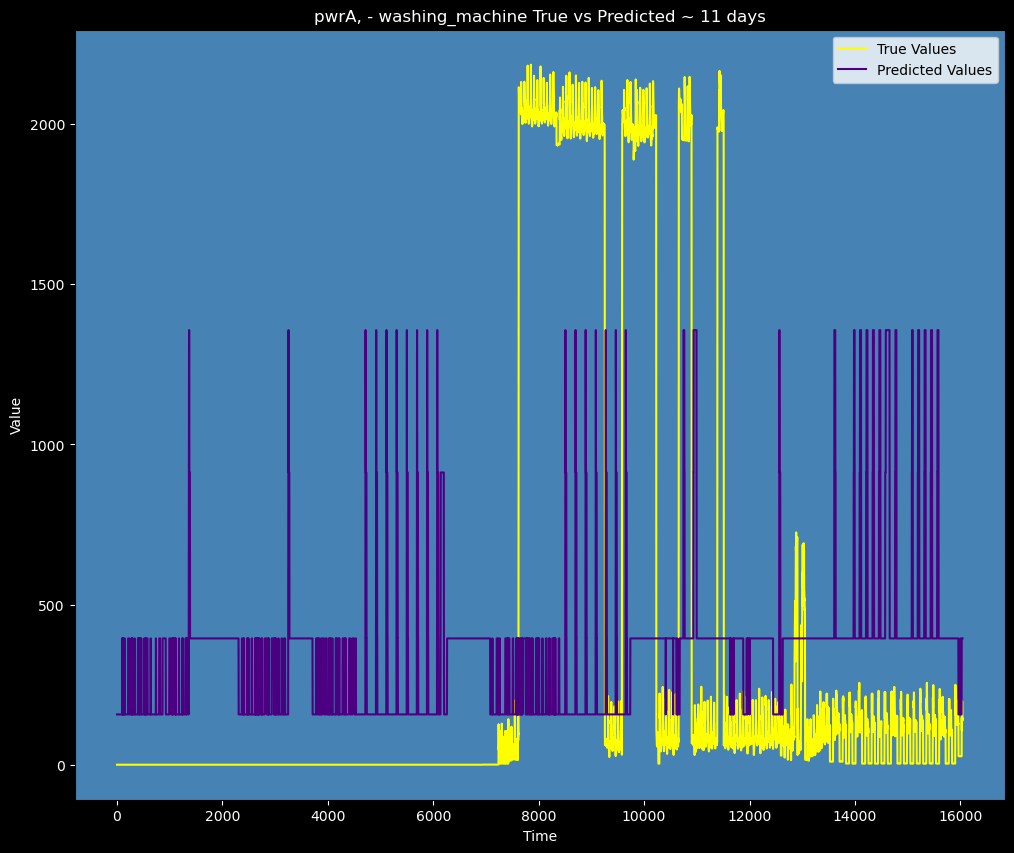

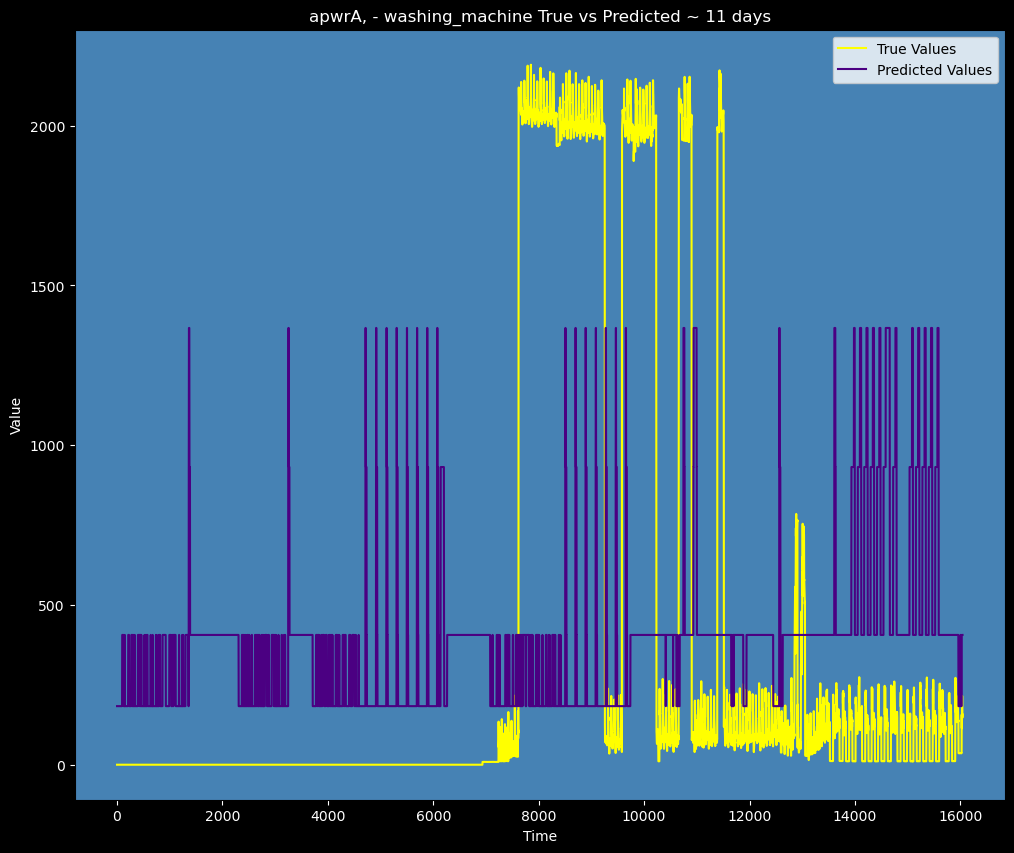

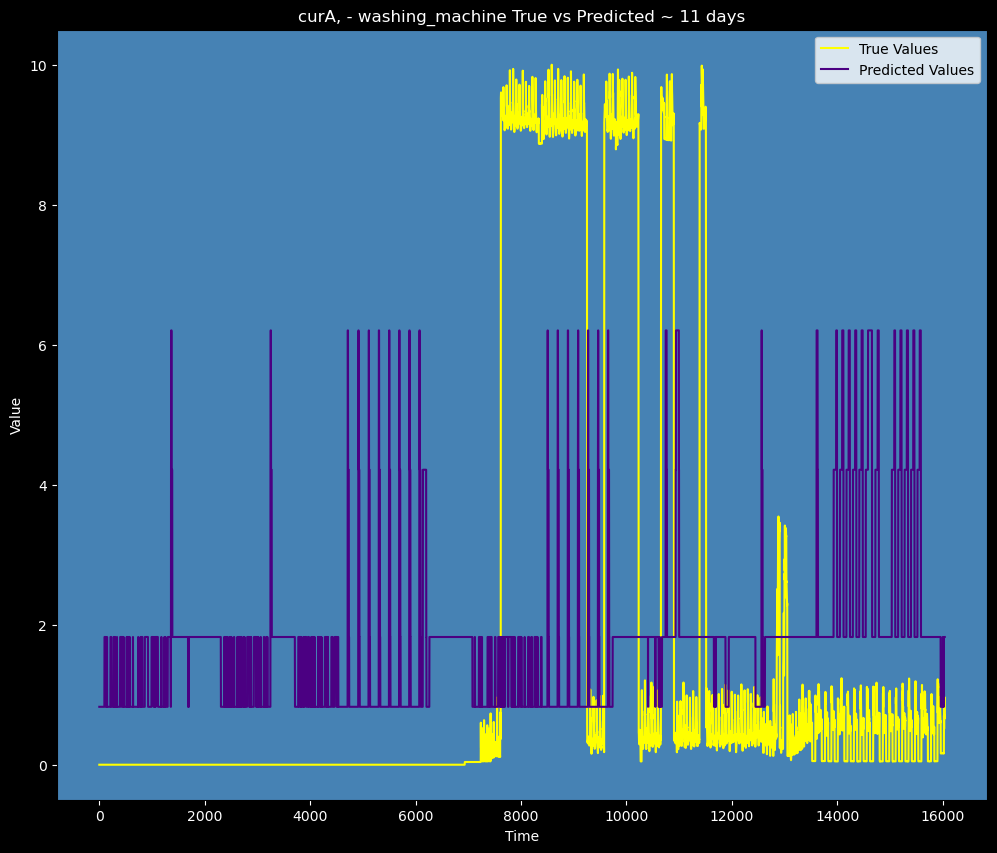

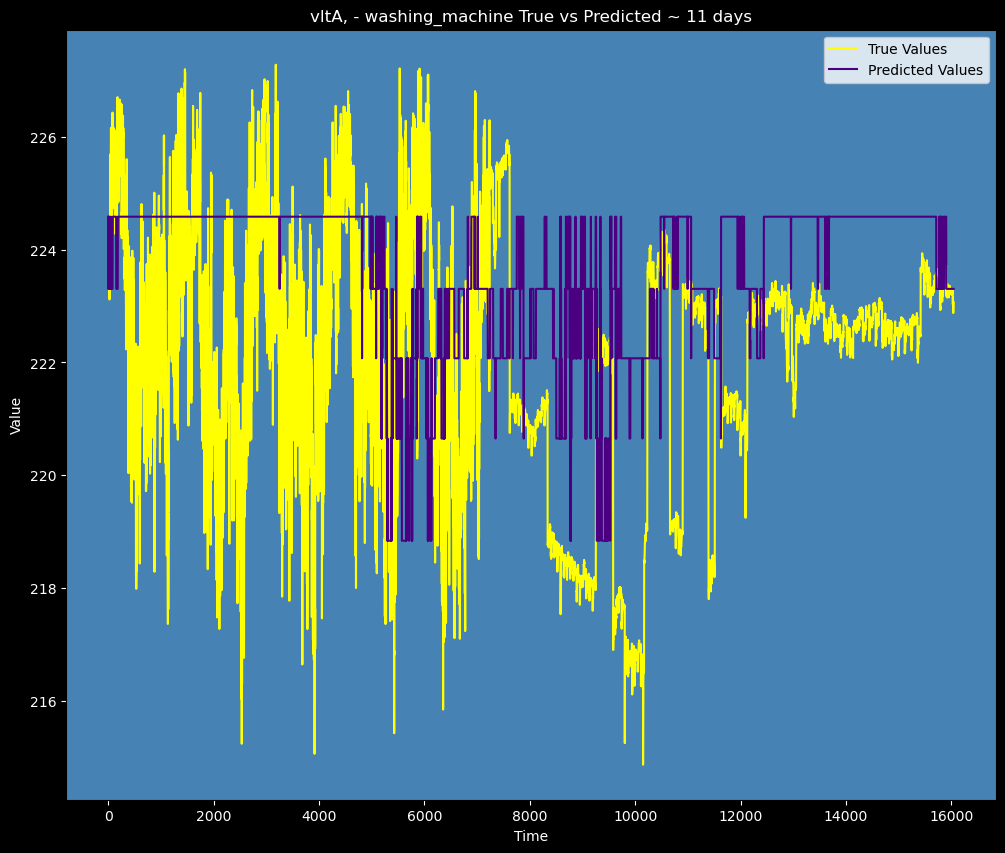

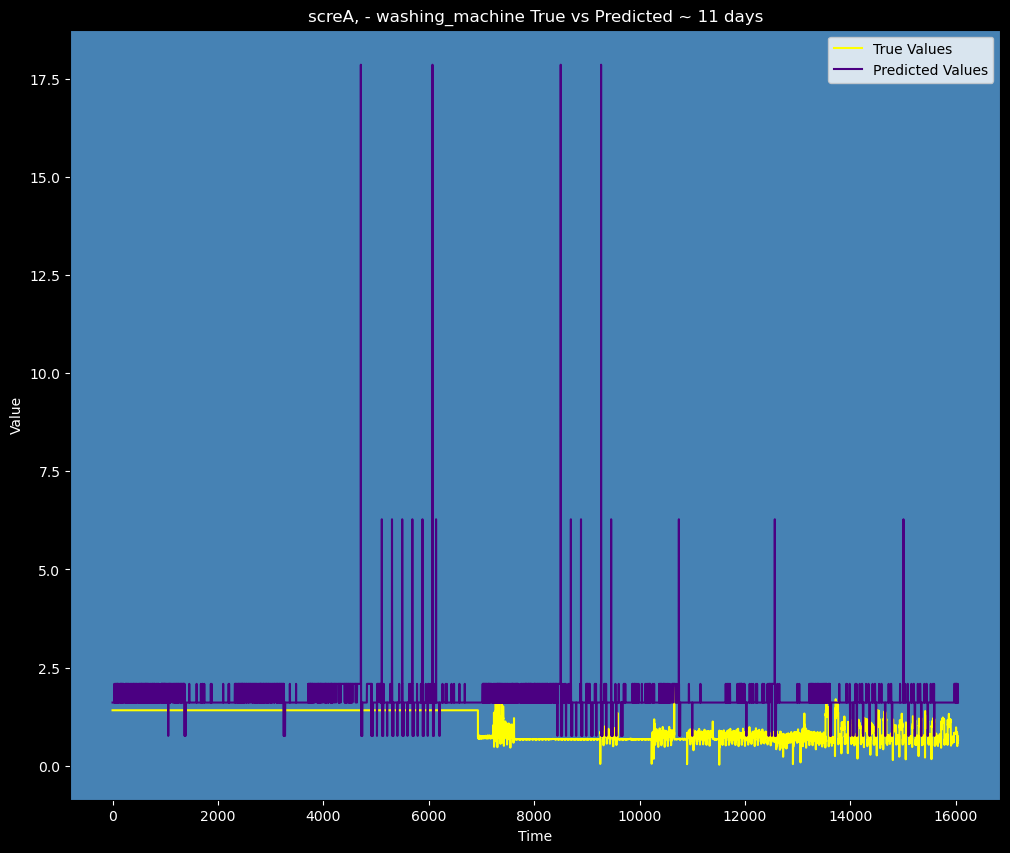

In [13]:
import matplotlib.pyplot as plt
column_names = ['pwrA', 'apwrA','curA', 'vltA','screA']
j = 0
# Plotting the predicted values against the true values for each column
for i in range(Y_test_washing_machine.shape[1]):
    column_name = f"Column {i+1}"
    column_true = Y_test_washing_machine[:, i]
    column_pred = disaggregated_data_washing_machine[:, i]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_facecolor('black')
    
    ax.plot(column_true, label="True Values", color='yellow')
    ax.plot(column_pred, label="Predicted Values", color = 'indigo')
    ax.set_xlabel("Time",color= 'white')
    ax.set_ylabel("Value", color = 'white')
    ax.set_title(column_names[j]+", - washing_machine True vs Predicted ~ 11 days", color = 'white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.legend()
    
    # Change the color of the plot background
    ax.set_facecolor('steelblue')
    
    plt.show()
    j +=1

In [14]:
 ## Dishwasher ##   
    
    
X_train_dishwasher, X_test_dishwasher, Y_train_dishwasher, Y_test_dishwasher = aggregated_train.values, aggregated_test.values, dishwasher_train.values, dishwasher_test.values

co_disaggregator_dishwasher = CO(num_states=5, num_cluster=5)
co_disaggregator_dishwasher.train(X_train_dishwasher)

disaggregated_data_dishwasher = co_disaggregator_dishwasher.disaggregate(X_test_dishwasher)

columns = ["pwrA", "apwrA", "curA", "cltA", "screA"]

# Create an empty dictionary to store the metrics
metrics = {}

# Calculate and store the metrics for each column
for column in columns:
    column_true = Y_test_dishwasher[:, columns.index(column)]
    column_pred = disaggregated_data_dishwasher[:, columns.index(column)]
    
    rmse = co_disaggregator_dishwasher.calculate_rmse(column_true, column_pred)
    mae = co_disaggregator_dishwasher.calculate_mae(column_true, column_pred)
    rmae = co_disaggregator_dishwasher.calculate_rmae(column_true, column_pred)
    mse = co_disaggregator_dishwasher.calculate_mse(column_true, column_pred)
    r_squared = r2_score(column_true, column_pred)
    
    metrics[column] = {
        'RMSE': rmse,
        'MAE': mae,
        'RMAE': rmae,
        'MSE': mse,
        'R-squared': r_squared
    }

# Print the metrics for each column
for column, metrics_dict in metrics.items():
    print(f"Metrics for {column}:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value}")
    print()


/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

Metrics for pwrA:
RMSE: 511.47773921385414
MAE: 386.00964346420454
RMAE: 9.209881114537241
MSE: 261609.47771131538
R-squared: -1.5888266960689048

Metrics for apwrA:
RMSE: 541.3693248400441
MAE: 423.19433301667374
RMAE: 8.460700874514316
MSE: 293080.7458777652
R-squared: -1.866889857731079

Metrics for curA:
RMSE: 2.406121286170589
MAE: 1.867765756737429
RMAE: 8.203094702671237
MSE: 5.789419643763211
R-squared: -1.6782440809614996

Metrics for cltA:
RMSE: 2.8978547316994874
MAE: 2.2935402152573476
RMAE: 0.013028536328917036
MSE: 8.397562046033109
R-squared: -0.727873034824984

Metrics for screA:
RMSE: 1.0106838133600295
MAE: 0.9009706970168632
RMAE: 1.0929409383819115
MSE: 1.0214817705879708
R-squared: -3.1954447425587524



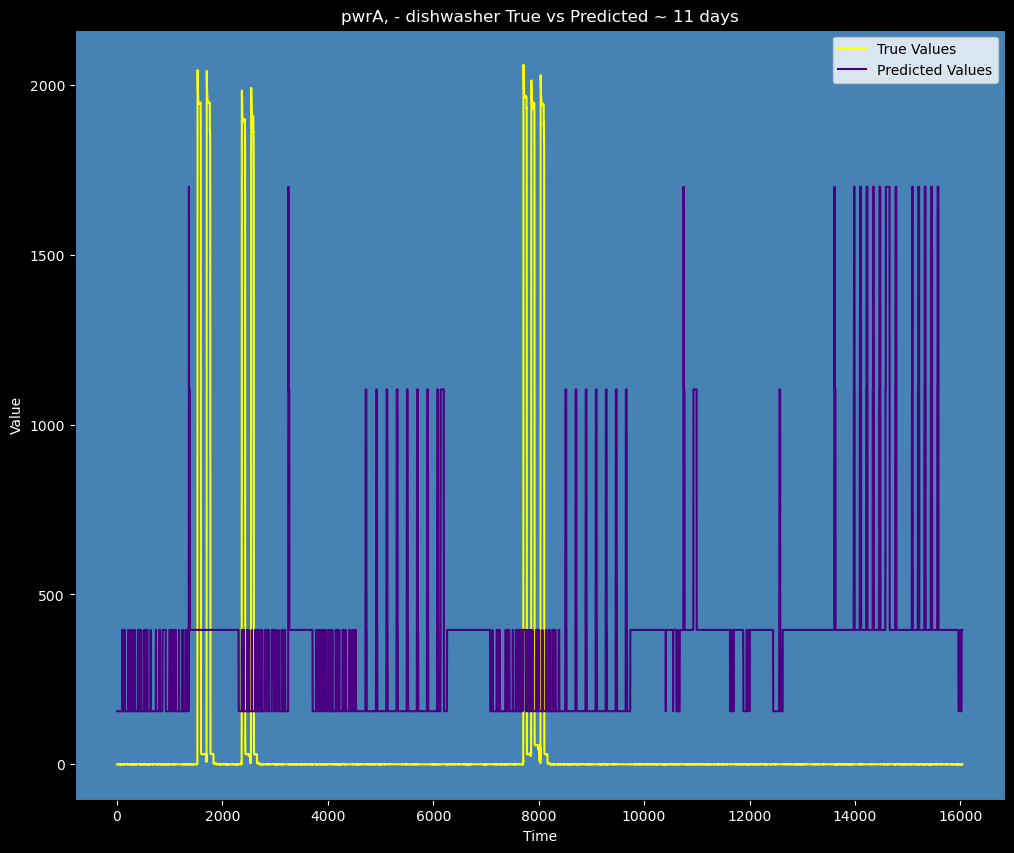

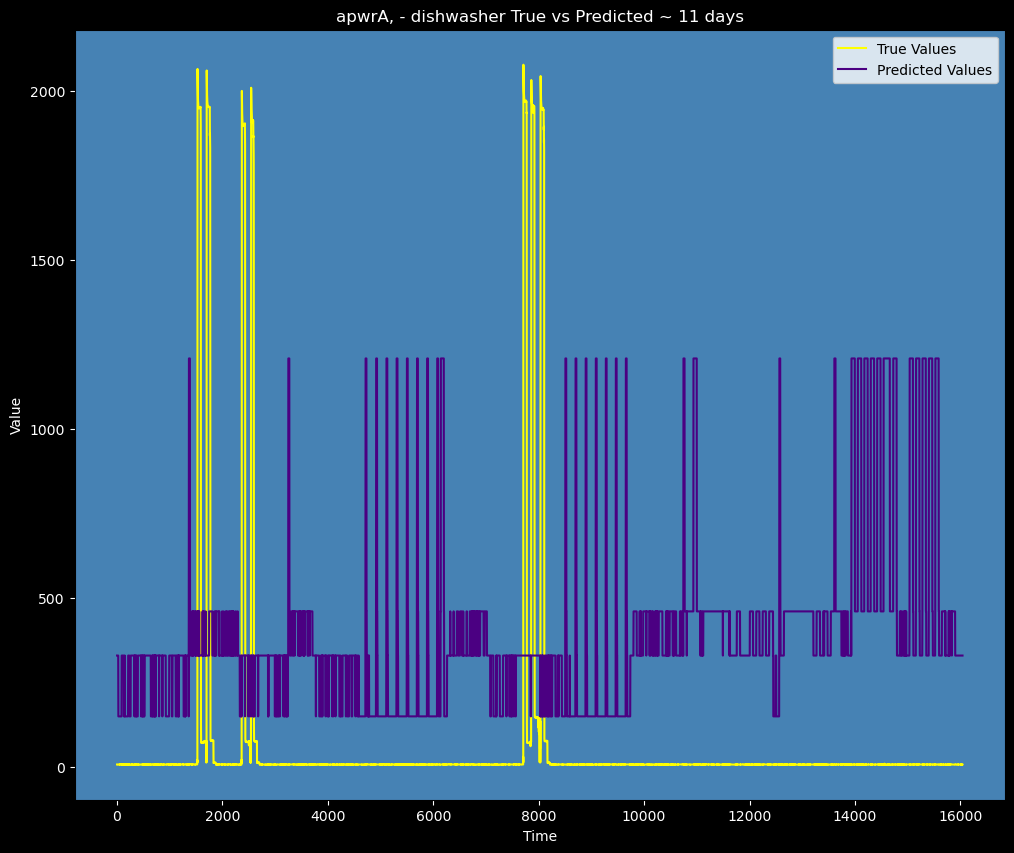

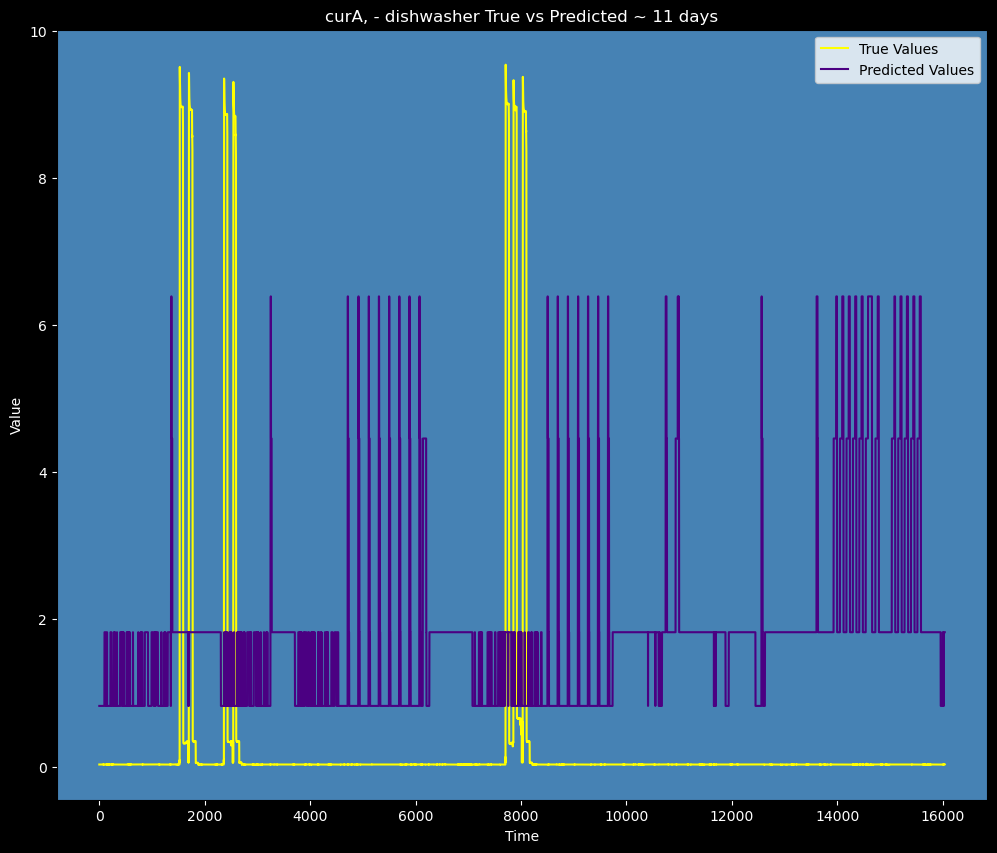

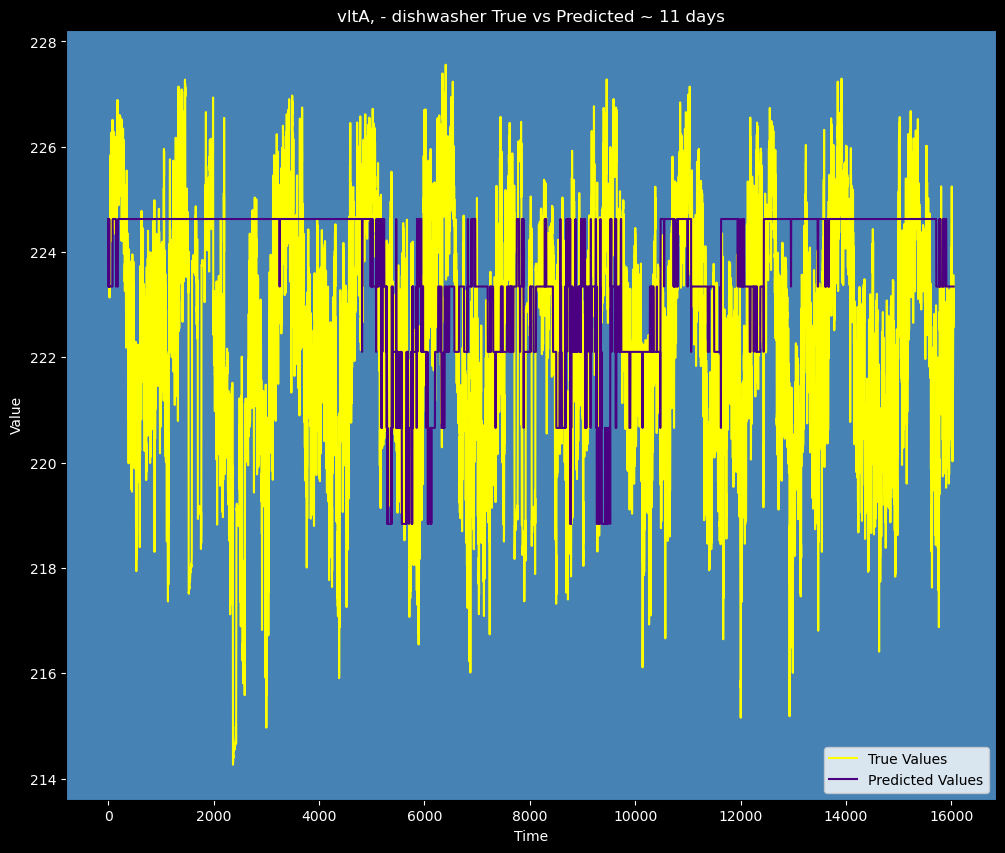

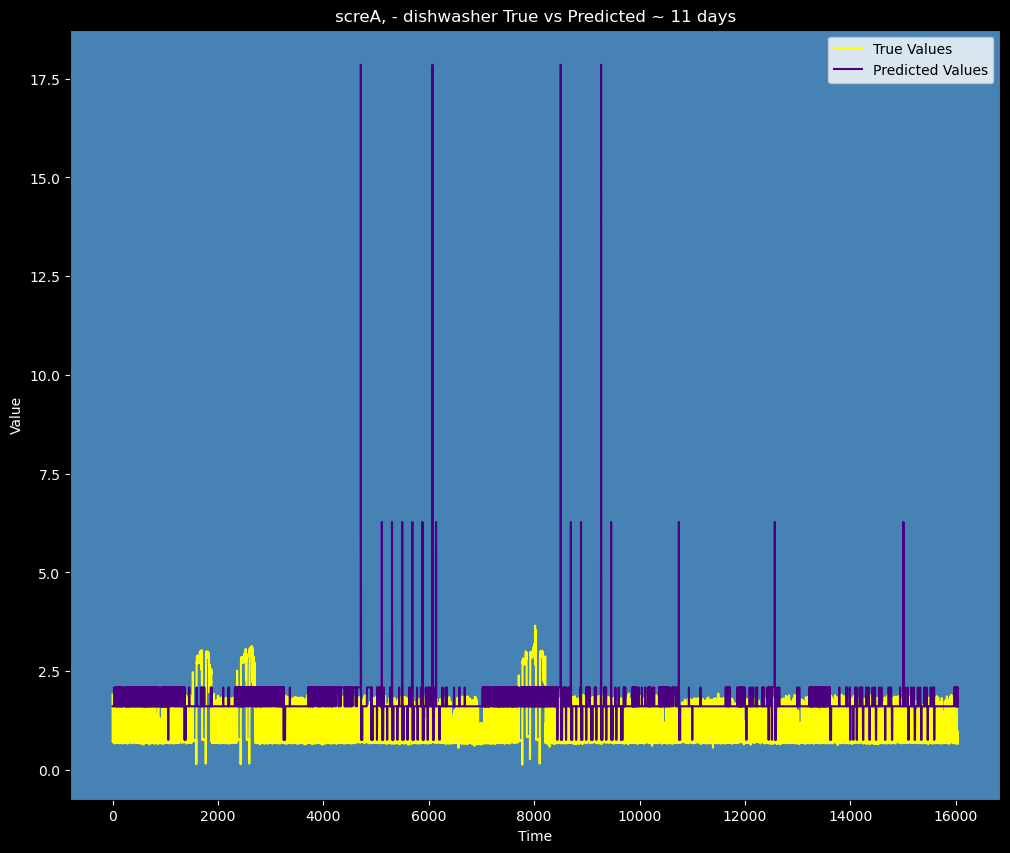

In [15]:
import matplotlib.pyplot as plt
column_names = ['pwrA', 'apwrA','curA', 'vltA','screA']
j = 0
# Plotting the predicted values against the true values for each column
for i in range(Y_test_dishwasher.shape[1]):
    column_name = f"Column {i+1}"
    column_true = Y_test_dishwasher[:, i]
    column_pred = disaggregated_data_dishwasher[:, i]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_facecolor('black')
    
    ax.plot(column_true, label="True Values", color='yellow')
    ax.plot(column_pred, label="Predicted Values", color = 'indigo')
    ax.set_xlabel("Time",color= 'white')
    ax.set_ylabel("Value", color = 'white')
    ax.set_title(column_names[j]+", - dishwasher True vs Predicted ~ 11 days", color = 'white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.legend()
    
    # Change the color of the plot background
    ax.set_facecolor('steelblue')
    
    plt.show()
    j +=1

In [16]:
 ## hotplate ##   
    
    
X_train_hotplate, X_test_hotplate, Y_train_hotplate, Y_test_hotplate = aggregated_train.values, aggregated_test.values, hotplate_train.values, hotplate_test.values

co_disaggregator_hotplate = CO(num_states=5, num_cluster=5)
co_disaggregator_hotplate.train(X_train_hotplate)

disaggregated_data_hotplate = co_disaggregator_hotplate.disaggregate(X_test_hotplate)

columns = ["pwrA", "apwrA", "curA", "cltA", "screA"]

# Create an empty dictionary to store the metrics
metrics = {}

# Calculate and store the metrics for each column
for column in columns:
    column_true = Y_test_hotplate[:, columns.index(column)]
    column_pred = disaggregated_data_hotplate[:, columns.index(column)]
    
    rmse = co_disaggregator_hotplate.calculate_rmse(column_true, column_pred)
    mae = co_disaggregator_hotplate.calculate_mae(column_true, column_pred)
    rmae = co_disaggregator_hotplate.calculate_rmae(column_true, column_pred)
    mse = co_disaggregator_hotplate.calculate_mse(column_true, column_pred)
    r_squared = r2_score(column_true, column_pred)
    
    metrics[column] = {
        'RMSE': rmse,
        'MAE': mae,
        'RMAE': rmae,
        'MSE': mse,
        'R-squared': r_squared
    }

# Print the metrics for each column
for column, metrics_dict in metrics.items():
    print(f"Metrics for {column}:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value}")
    print()


/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

Metrics for pwrA:
RMSE: 430.02332238508313
MAE: 352.7773036292578
RMAE: 12.264573761282008
MSE: 184920.05779510515
R-squared: -3.755535034494251

Metrics for apwrA:
RMSE: 473.6614927709656
MAE: 392.48219437254176
RMAE: 13.391402026392221
MSE: 224355.2097340195
R-squared: -4.696076683923643

Metrics for curA:
RMSE: 2.1321089995493794
MAE: 1.7624314181151375
RMAE: 13.32959695131235
MSE: 4.545888785959456
R-squared: -4.638349698179272

Metrics for cltA:
RMSE: 2.67030363924543
MAE: 2.156009004236336
RMAE: 0.011993680733970712
MSE: 7.130521525767387
R-squared: -0.6469210029633659

Metrics for screA:
RMSE: 0.5444749538165166
MAE: 0.3603252211240844
RMAE: 0.3932000472285047
MSE: 0.29645297533349785
R-squared: -11.57338509254631



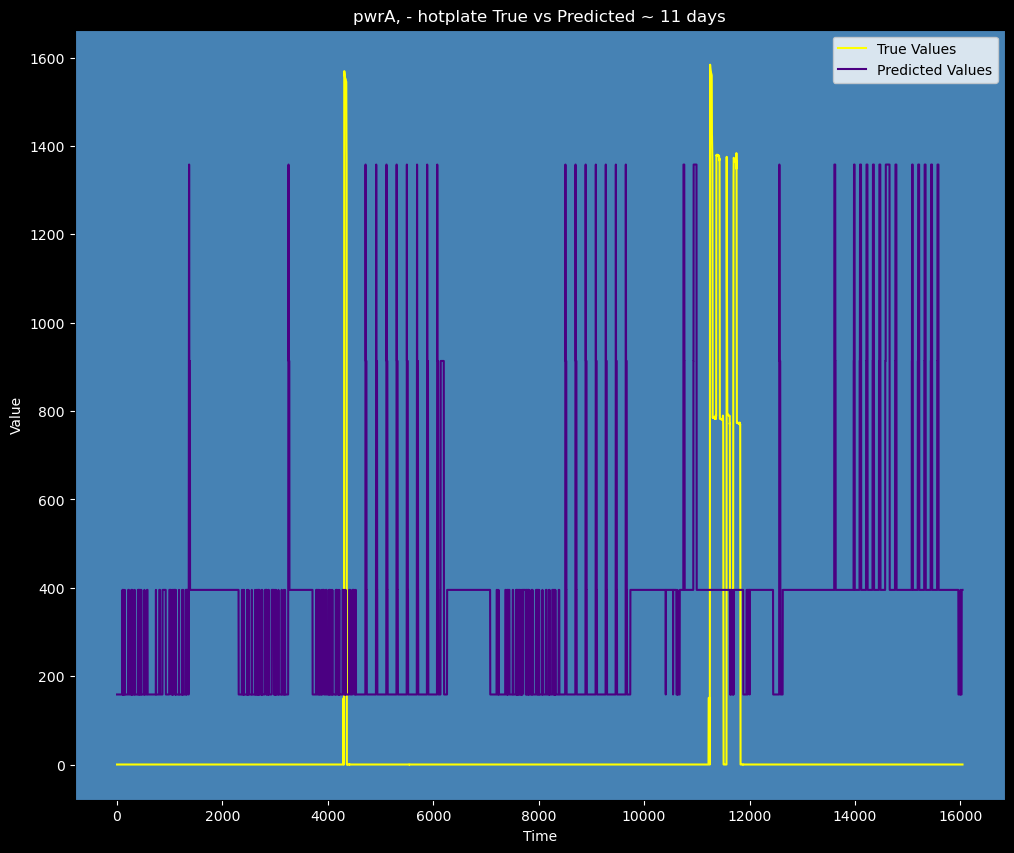

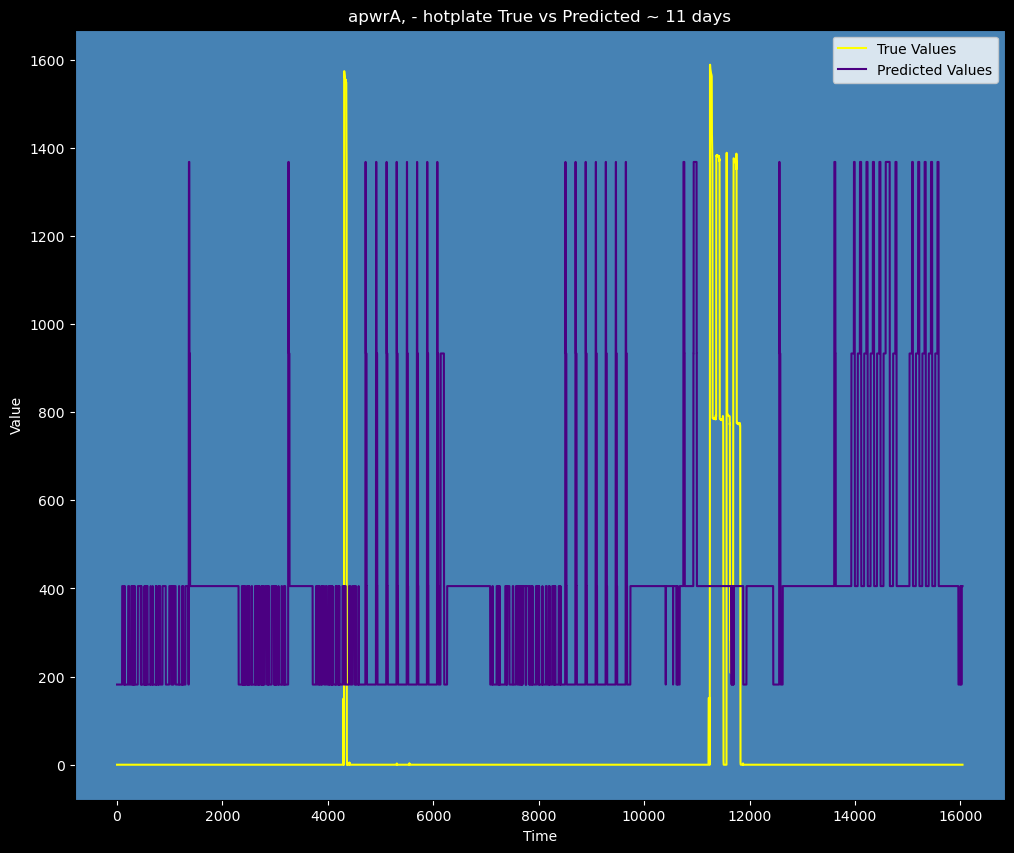

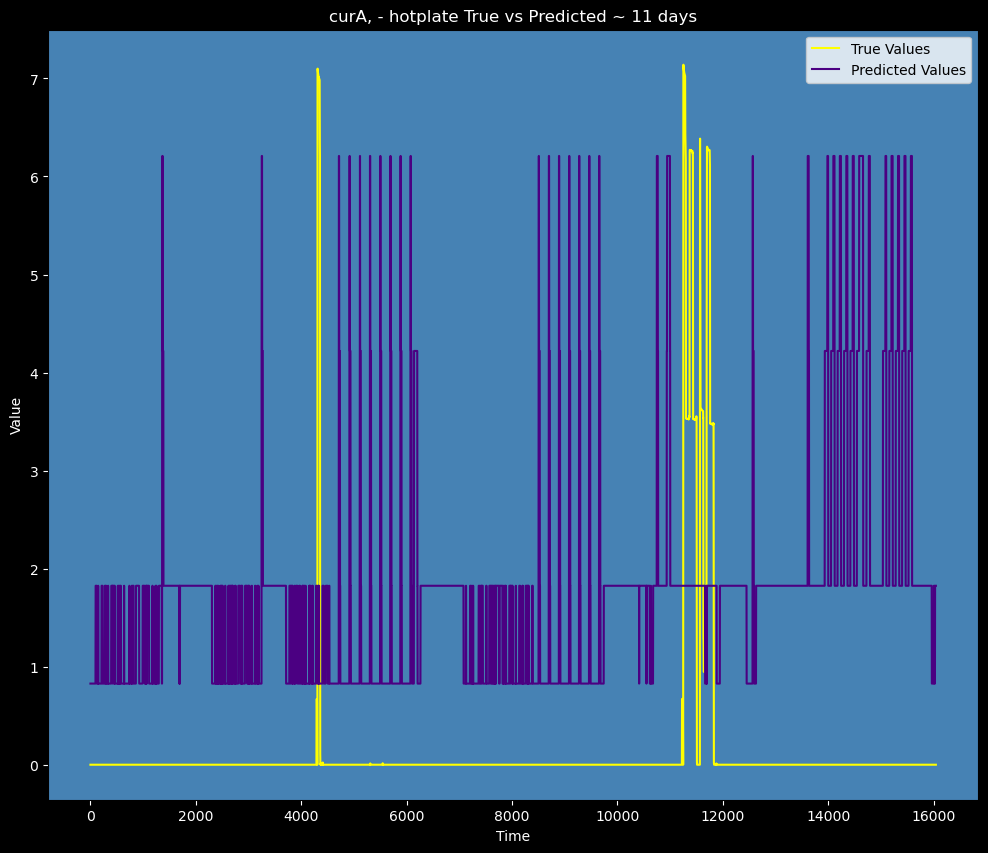

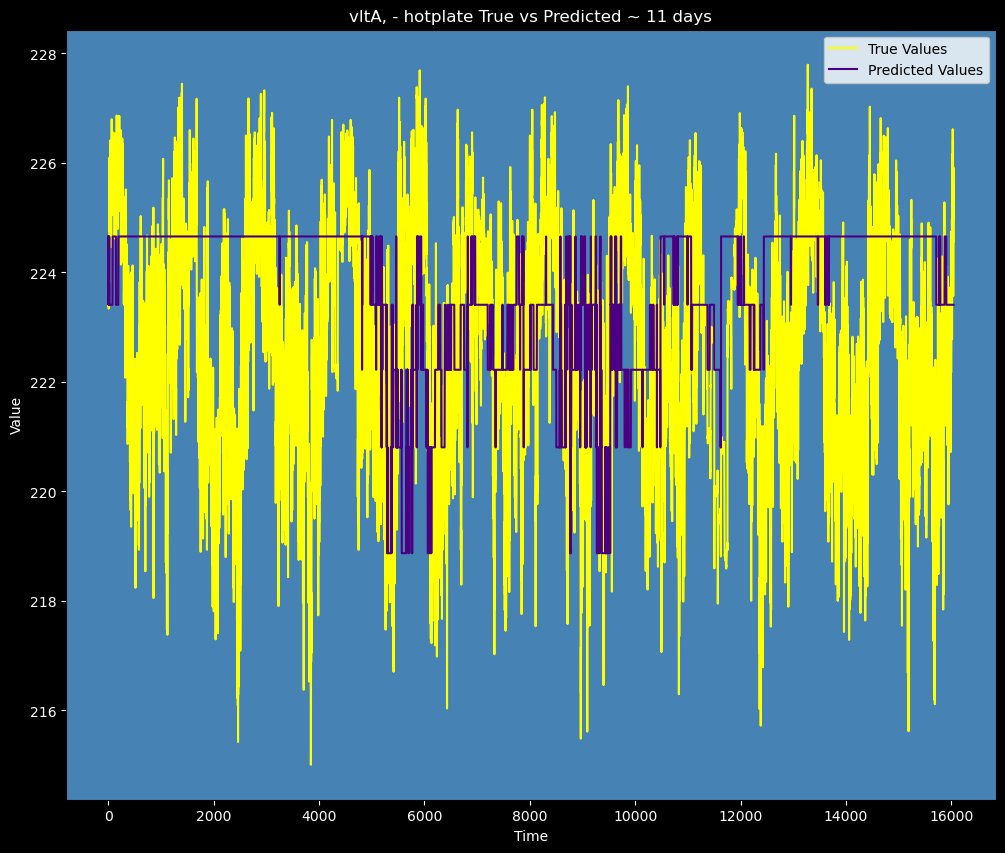

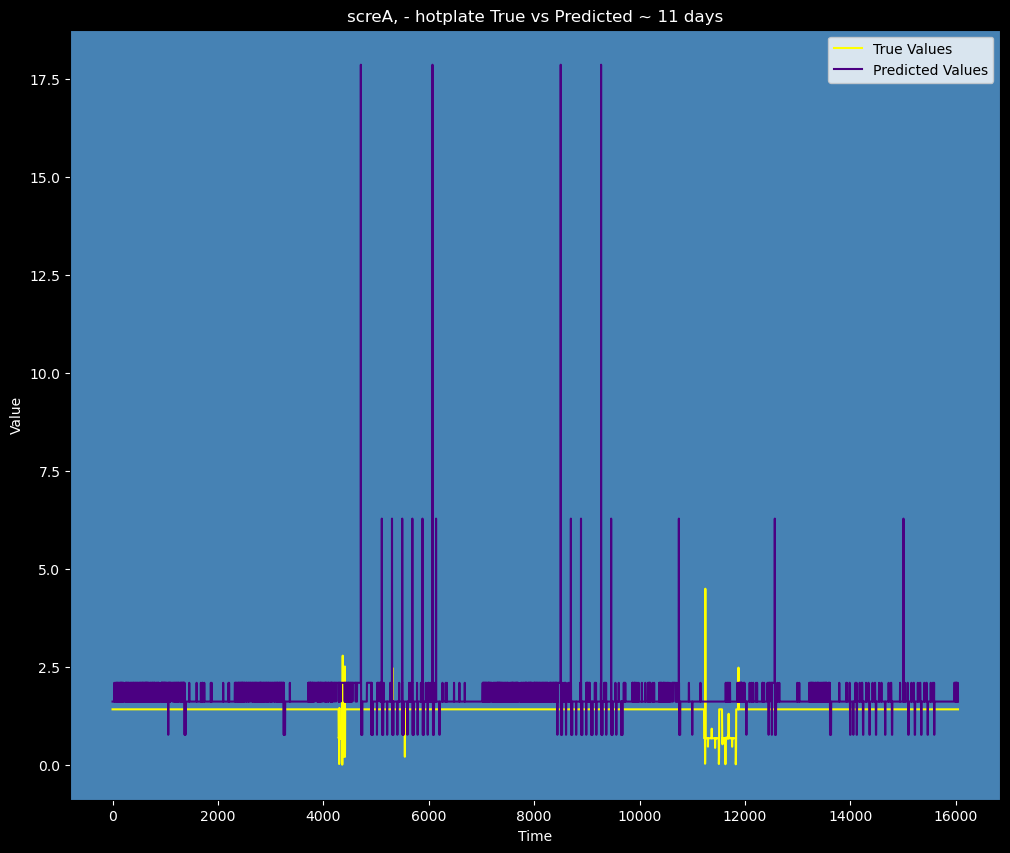

In [17]:
import matplotlib.pyplot as plt
column_names = ['pwrA', 'apwrA','curA', 'vltA','screA']
j = 0
# Plotting the predicted values against the true values for each column
for i in range(Y_test_hotplate.shape[1]):
    column_name = f"Column {i+1}"
    column_true = Y_test_hotplate[:, i]
    column_pred = disaggregated_data_hotplate[:, i]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_facecolor('black')
    
    ax.plot(column_true, label="True Values", color='yellow')
    ax.plot(column_pred, label="Predicted Values", color = 'indigo')
    ax.set_xlabel("Time",color= 'white')
    ax.set_ylabel("Value", color = 'white')
    ax.set_title(column_names[j]+", - hotplate True vs Predicted ~ 11 days", color = 'white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.legend()
    
    # Change the color of the plot background
    ax.set_facecolor('steelblue')
    
    plt.show()
    j +=1

In [20]:
 ## microwave ##   
    
    
X_train_microwave, X_test_microwave, Y_train_microwave, Y_test_microwave = aggregated_train.values, aggregated_test.values, microwave_train.values, microwave_test.values

co_disaggregator_microwave = CO(num_states=5, num_cluster=5)
co_disaggregator_microwave.train(X_train_microwave)

disaggregated_data_microwave = co_disaggregator_microwave.disaggregate(X_test_microwave)

columns = ["pwrA", "apwrA", "curA", "cltA", "screA"]

# Create an empty dictionary to store the metrics
metrics = {}

# Calculate and store the metrics for each column
for column in columns:
    column_true = Y_test_microwave[:, columns.index(column)]
    column_pred = disaggregated_data_microwave[:, columns.index(column)]
    
    rmse = co_disaggregator_microwave.calculate_rmse(column_true, column_pred)
    mae = co_disaggregator_microwave.calculate_mae(column_true, column_pred)
    rmae = co_disaggregator_microwave.calculate_rmae(column_true, column_pred)
    mse = co_disaggregator_microwave.calculate_mse(column_true, column_pred)
    r_squared = r2_score(column_true, column_pred)
    
    metrics[column] = {
        'RMSE': rmse,
        'MAE': mae,
        'RMAE': rmae,
        'MSE': mse,
        'R-squared': r_squared
    }

# Print the metrics for each column
for column, metrics_dict in metrics.items():
    print(f"Metrics for {column}:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value}")
    print()


/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

Metrics for pwrA:
RMSE: 441.125776946118
MAE: 341.33828604726136
RMAE: 3.3410275337926163
MSE: 194591.95108631626
R-squared: -0.6348821199888663

Metrics for apwrA:
RMSE: 467.6189335223672
MAE: 376.7396673267222
RMAE: 2.238564239638364
MSE: 218667.46698859605
R-squared: -0.3211778089829267

Metrics for curA:
RMSE: 2.1100429313754896
MAE: 1.6948995604385715
RMAE: 2.2461080459838207
MSE: 4.45228117224767
R-squared: -0.3238027989025434

Metrics for cltA:
RMSE: 2.3885263510823243
MAE: 1.9230132929155777
RMAE: 0.010704683996965524
MSE: 5.705058129814643
R-squared: -0.01137131101118416

Metrics for screA:
RMSE: 0.9928953017224803
MAE: 0.8959888498503773
RMAE: 1.2026770566953187
MSE: 0.9858410801825752
R-squared: -33.955316596958234



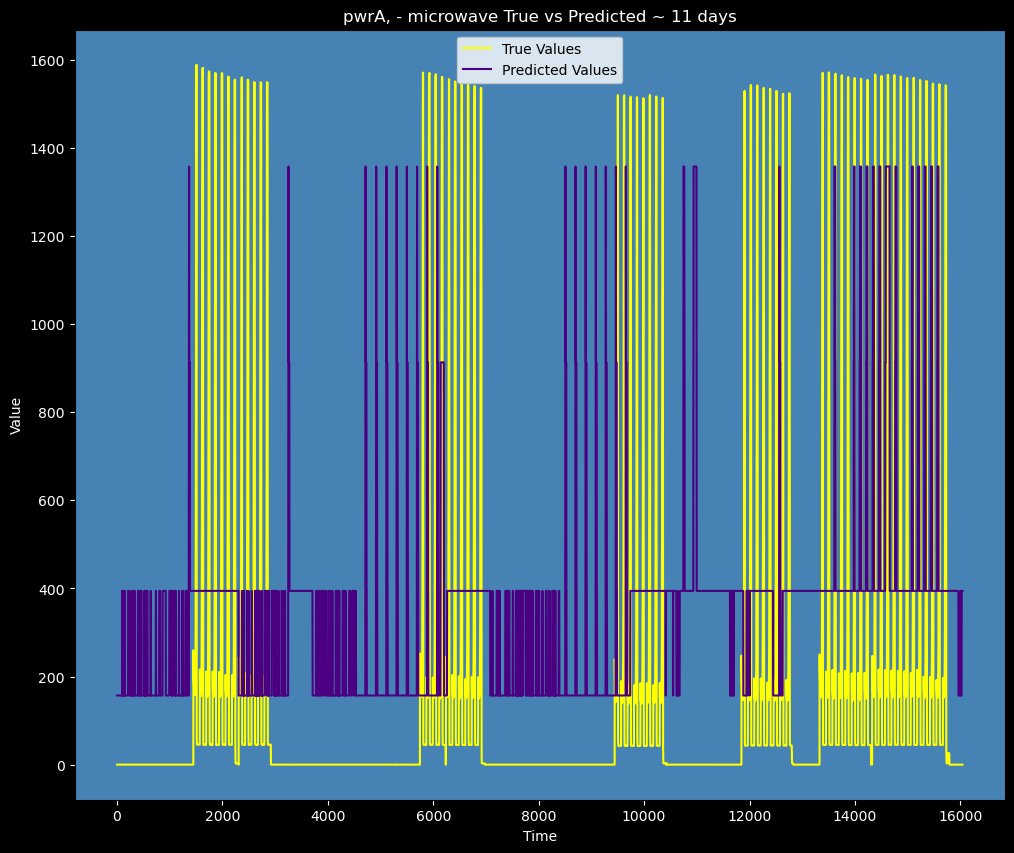

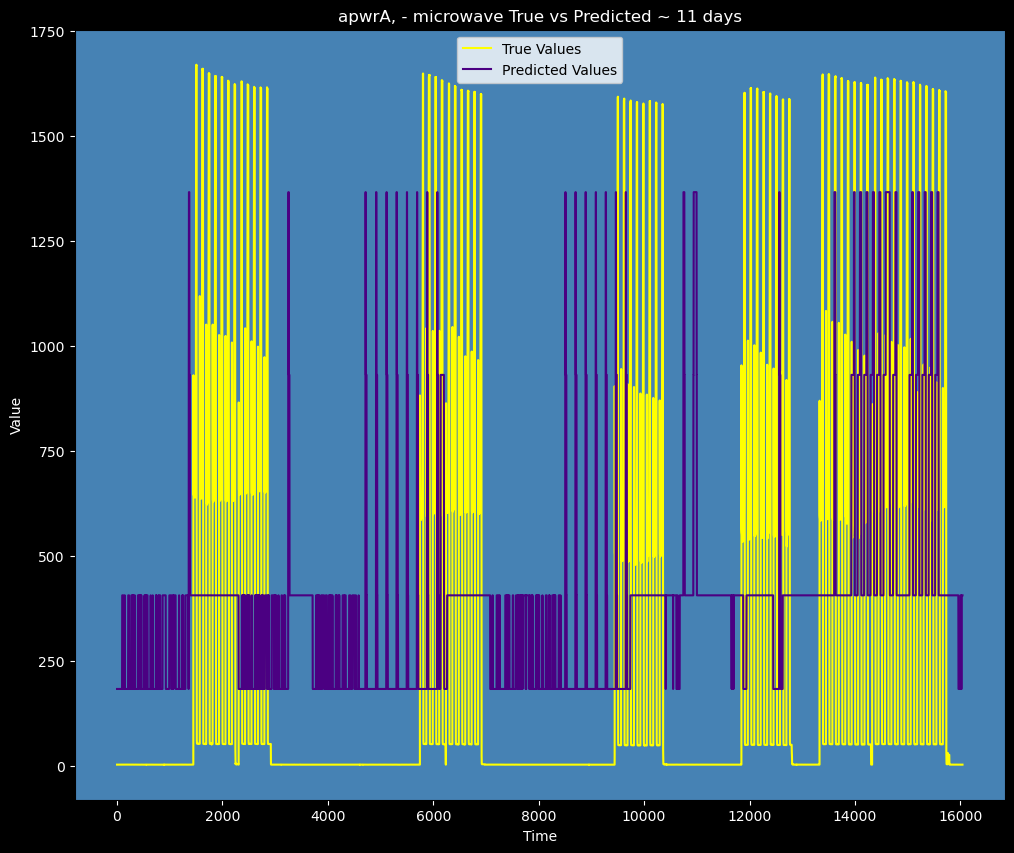

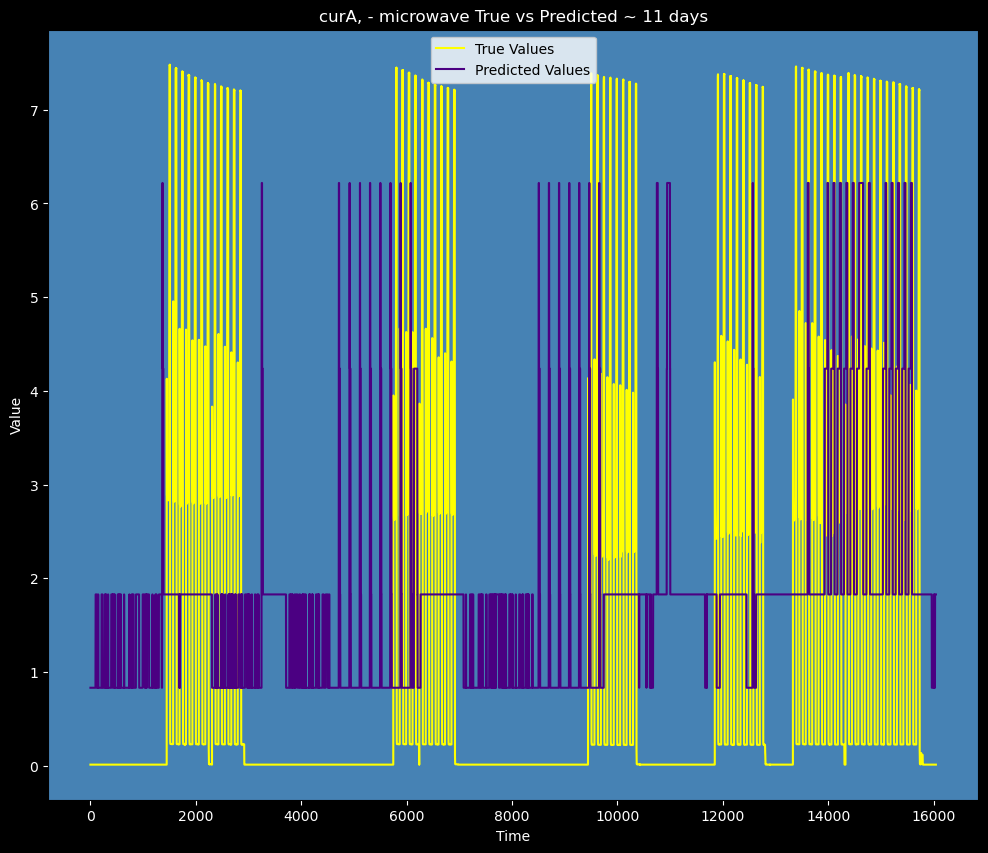

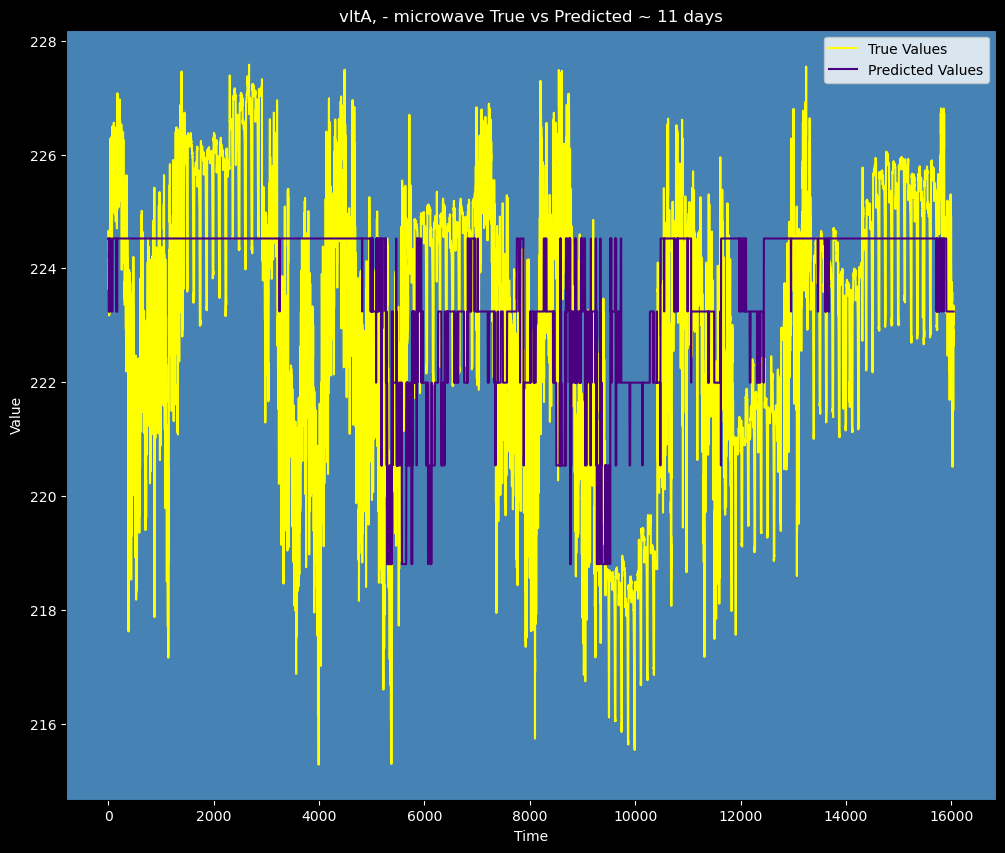

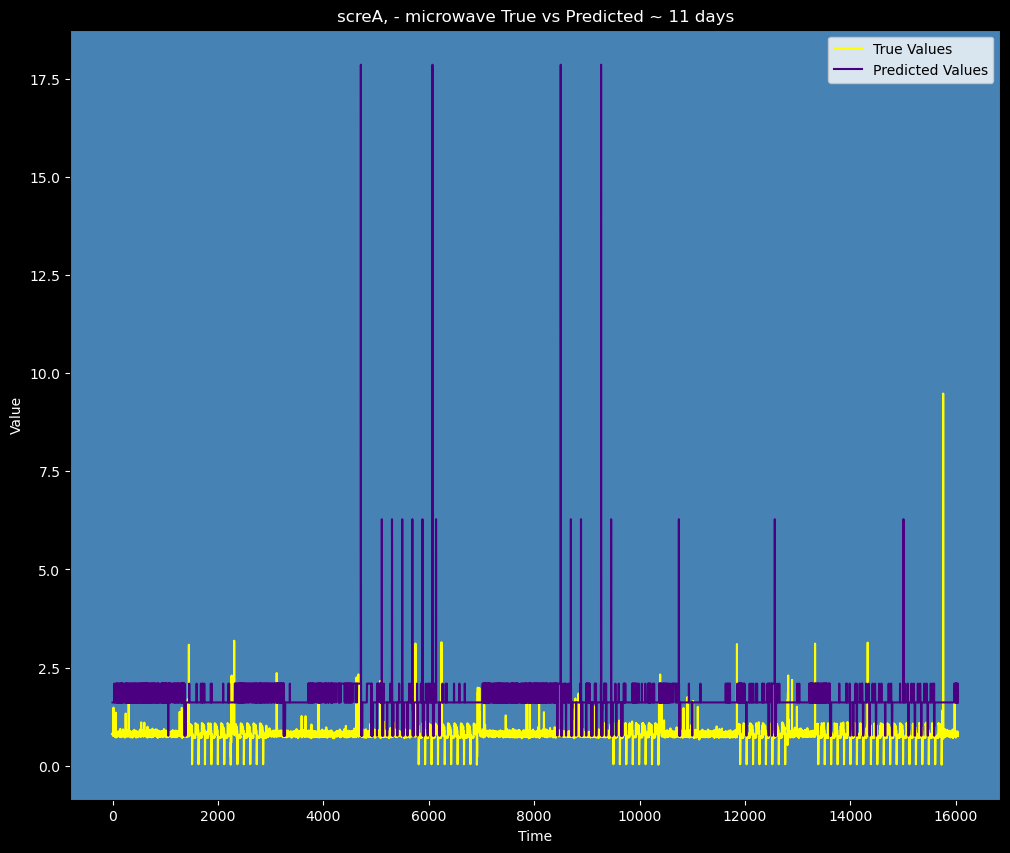

In [21]:
import matplotlib.pyplot as plt
column_names = ['pwrA', 'apwrA','curA', 'vltA','screA']
j = 0
# Plotting the predicted values against the true values for each column
for i in range(Y_test_microwave.shape[1]):
    column_name = f"Column {i+1}"
    column_true = Y_test_microwave[:, i]
    column_pred = disaggregated_data_microwave[:, i]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_facecolor('black')
    
    ax.plot(column_true, label="True Values", color='yellow')
    ax.plot(column_pred, label="Predicted Values", color = 'indigo')
    ax.set_xlabel("Time",color= 'white')
    ax.set_ylabel("Value", color = 'white')
    ax.set_title(column_names[j]+", - microwave True vs Predicted ~ 11 days", color = 'white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.legend()
    
    # Change the color of the plot background
    ax.set_facecolor('steelblue')
    
    plt.show()
    j +=1

In [18]:
 ## water_heater ##   
    
    
X_train_water_heater, X_test_water_heater, Y_train_water_heater, Y_test_water_heater = aggregated_train.values, aggregated_test.values, water_heater_train.values, water_heater_test.values

co_disaggregator_water_heater = CO(num_states=5, num_cluster=5)
co_disaggregator_water_heater.train(X_train_water_heater)

disaggregated_data_water_heater = co_disaggregator_water_heater.disaggregate(X_test_water_heater)

columns = ["pwrA", "apwrA", "curA", "cltA", "screA"]

# Create an empty dictionary to store the metrics
metrics = {}

# Calculate and store the metrics for each column
for column in columns:
    column_true = Y_test_water_heater[:, columns.index(column)]
    column_pred = disaggregated_data_water_heater[:, columns.index(column)]
    
    rmse = co_disaggregator_water_heater.calculate_rmse(column_true, column_pred)
    mae = co_disaggregator_water_heater.calculate_mae(column_true, column_pred)
    rmae = co_disaggregator_water_heater.calculate_rmae(column_true, column_pred)
    mse = co_disaggregator_water_heater.calculate_mse(column_true, column_pred)
    r_squared = r2_score(column_true, column_pred)
    
    metrics[column] = {
        'RMSE': rmse,
        'MAE': mae,
        'RMAE': rmae,
        'MSE': mse,
        'R-squared': r_squared
    }

# Print the metrics for each column
for column, metrics_dict in metrics.items():
    print(f"Metrics for {column}:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value}")
    print()


/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

Metrics for pwrA:
RMSE: 412.81352622690576
MAE: 343.22691560802514
RMAE: -4134.555395350854
MSE: 170415.0074358922
R-squared: -3508581.747774941

Metrics for apwrA:
RMSE: 452.02562816357903
MAE: 375.78581072672296
RMAE: 54.28239394276628
MSE: 204327.1685166782
R-squared: -10530872.754245171

Metrics for curA:
RMSE: 2.035480180163302
MAE: 1.688538003739653
RMAE: 54.6983641504732
MSE: 4.143179563837627
R-squared: -10972428.305595055

Metrics for cltA:
RMSE: 0.9763245217860133
MAE: 0.7523581496758739
RMAE: 0.004352405026829435
MSE: 0.9532095718406874
R-squared: 0.7122418238274469

Metrics for screA:
RMSE: 0.9195972376284417
MAE: 0.7257742832204742
RMAE: 0.38713350133850893
MSE: 0.8456590794538607
R-squared: -2.5834542571108456



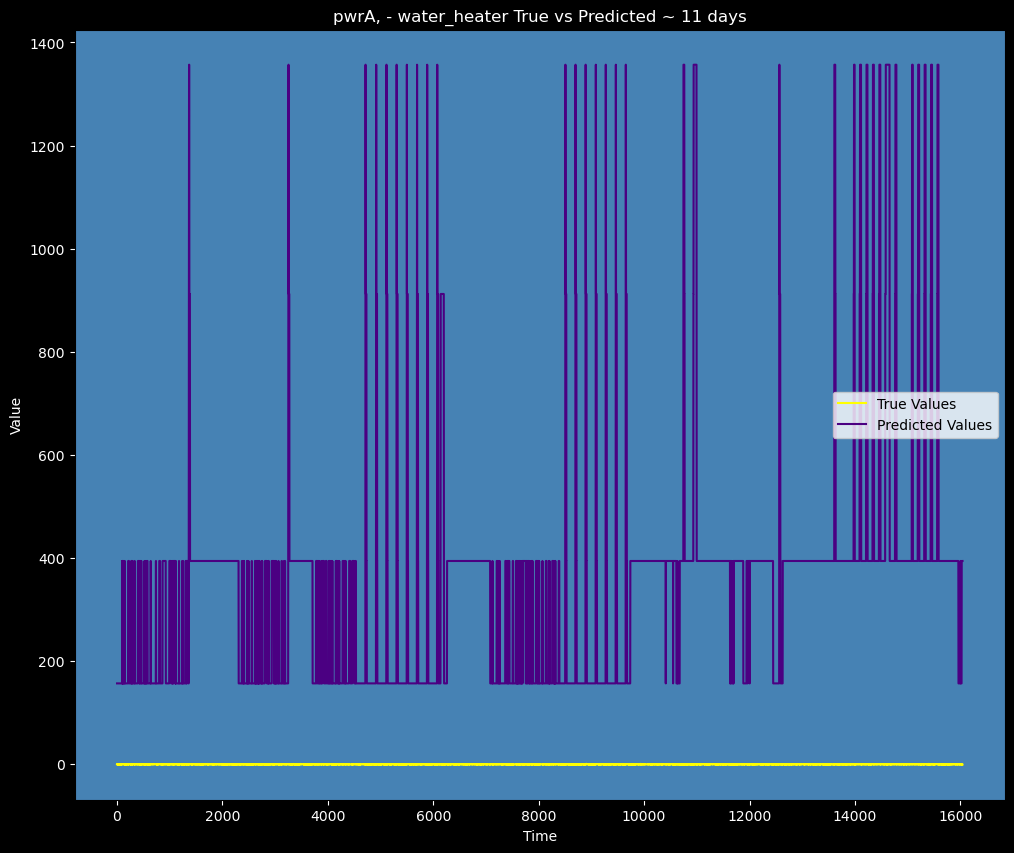

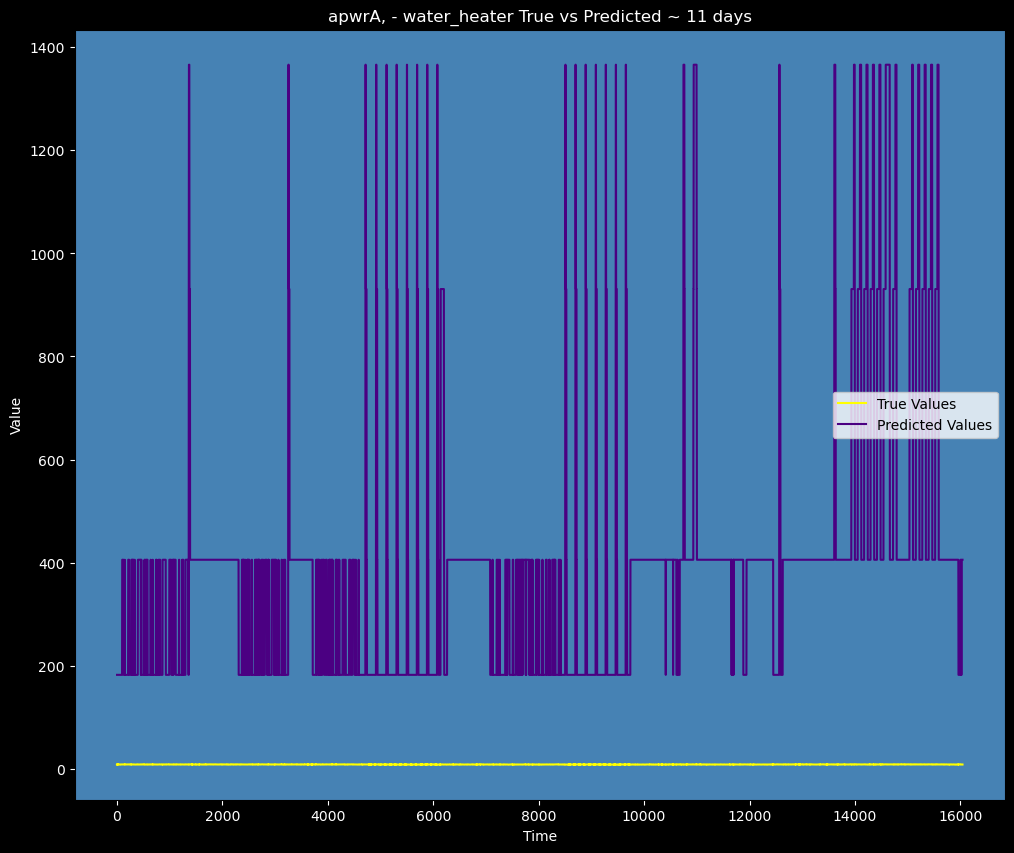

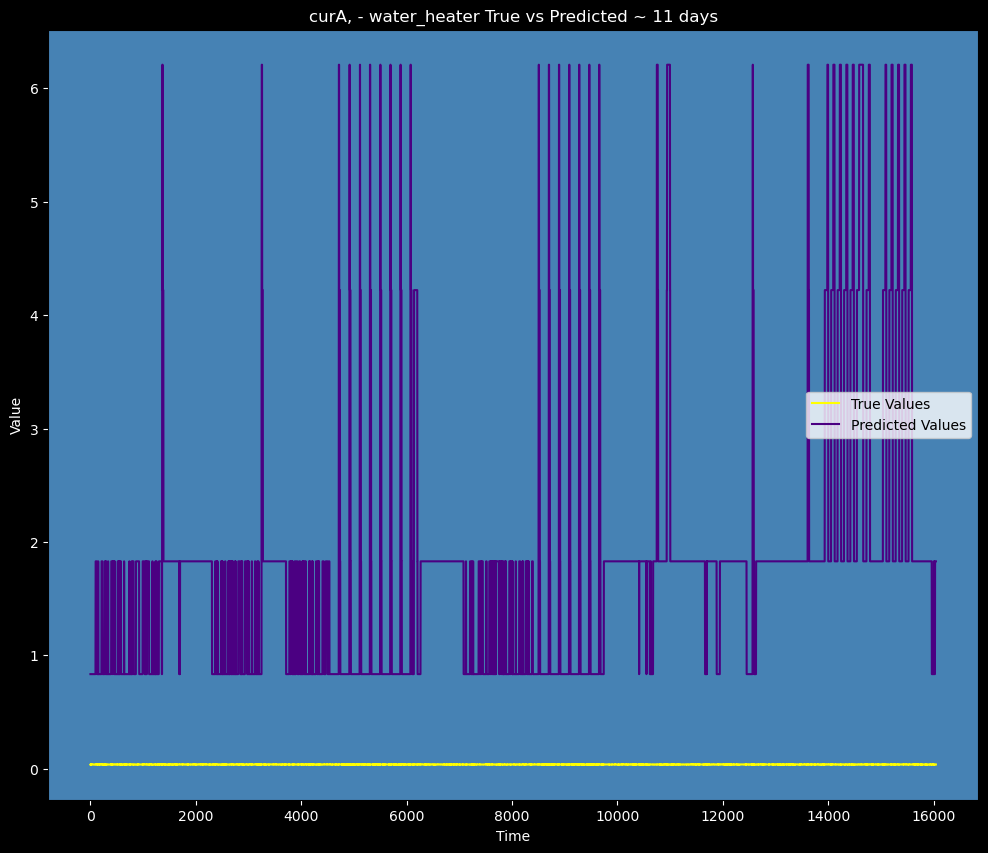

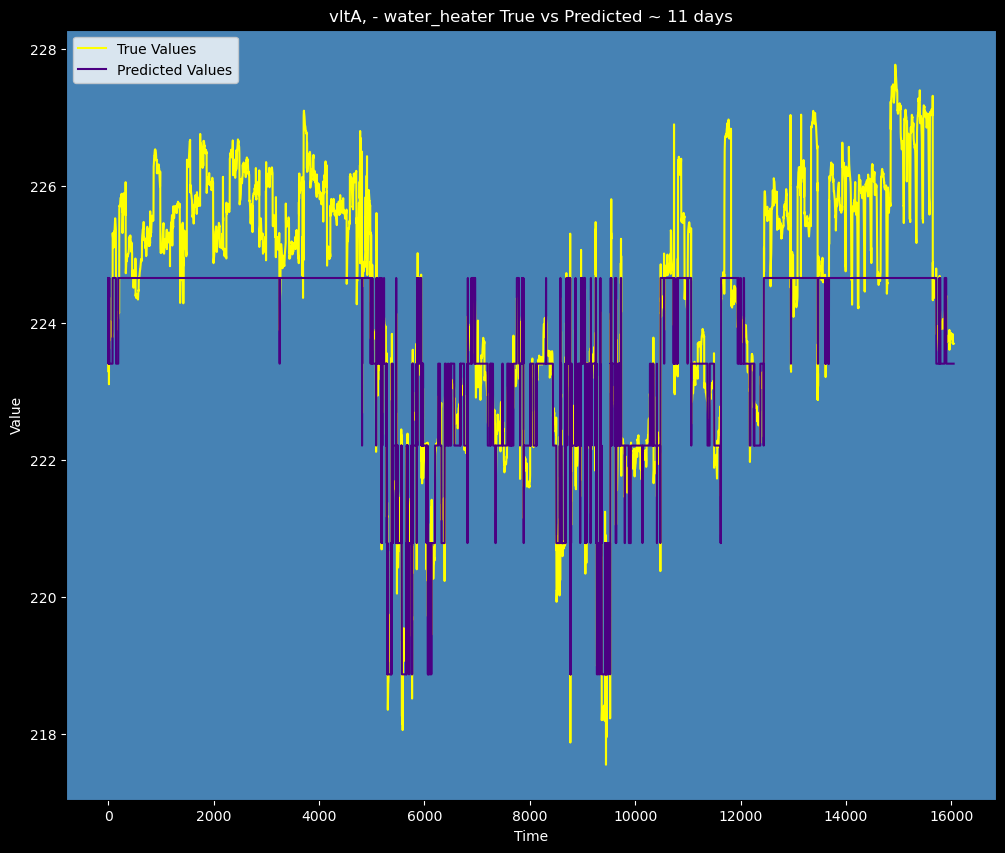

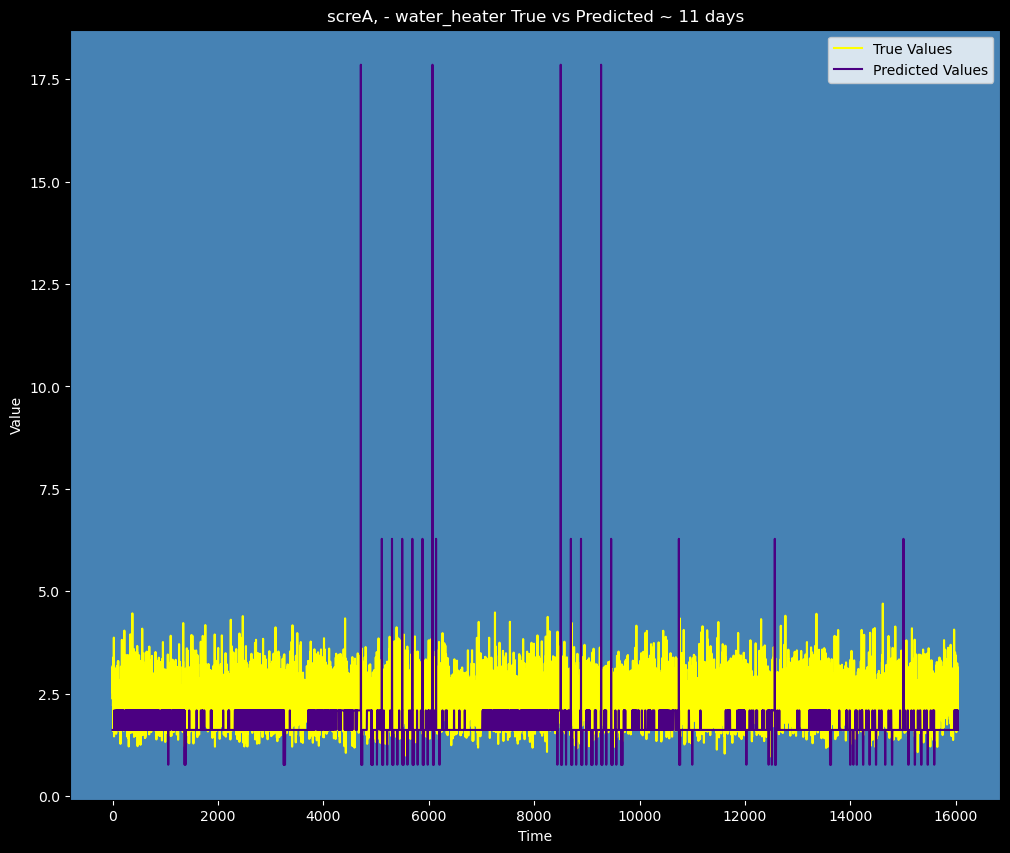

In [19]:
import matplotlib.pyplot as plt
column_names = ['pwrA', 'apwrA','curA', 'vltA','screA']
j = 0
# Plotting the predicted values against the true values for each column
for i in range(Y_test_water_heater.shape[1]):
    column_name = f"Column {i+1}"
    column_true = Y_test_water_heater[:, i]
    column_pred = disaggregated_data_water_heater[:, i]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_facecolor('black')
    
    ax.plot(column_true, label="True Values", color='yellow')
    ax.plot(column_pred, label="Predicted Values", color = 'indigo')
    ax.set_xlabel("Time",color= 'white')
    ax.set_ylabel("Value", color = 'white')
    ax.set_title(column_names[j]+", - water_heater True vs Predicted ~ 11 days", color = 'white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.legend()
    
    # Change the color of the plot background
    ax.set_facecolor('steelblue')
    
    plt.show()
    j +=1